In [13]:
from  nilearn import plotting
%matplotlib inline
import os
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
import pandas as pd

In [14]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [15]:
experiment_dir  = '/data/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

task_list = ['tom']

In [4]:
subject_list = os.listdir("/data/wellbeing_bids")
subject_list.remove('dataset_description.json')

subject_list = [sub[-4:] for sub in subject_list]

In [26]:
# TR of functional images
TR = 2

# Smoothing withds used during preprocessing
fwhm = [4, 8]

In [27]:
# SpecifyModel - Generates SPM-specific Model# Speci 
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

In [28]:
# Condition names# Condi 
condition_names = ['belief','photo']

# Contrasts
cont01 = ['Average', 'T', condition_names, [0.5,0.5]]
cont02 = ['belief', 'T', condition_names, [1, 0]]
cont03 = ['photo', 'T', condition_names, [0, 1]]
cont04 = ['belief > photo', 'T', condition_names, [1, -1]]

cont05 = ['activation', 'F', [cont02, cont03]]

contrast_list = [cont01, cont02, cont03, cont04, cont05]

In [29]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/data/wellbeing_bids/sub-%s/func/sub-%s_task-tom_events.tsv' % (subject_id,subject_id))
    trialinfo['iCond'] = trialinfo['iCond'].apply({1:'belief',2:'photo'}.get)
    trialinfo.head()
    d = {'belief':1,'photo':2}
    conditions = []
    onsets = []
    durations = []

    for group in sorted(trialinfo.groupby('iCond'), key=lambda x:d[x[0]]):
        conditions.append(group[0])
        onsets.append(list(group[1].onset))
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations)]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [30]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'task_name',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_name}',
                         'fwhm-{fwhm_id}_sasub-{subject_id}_task-{task_name}_bold.nii'),
             'mc_param': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_name}',
                             'asub-{subject_id}_task-{task_name}_bold.par'),
             'outliers': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_name}', 
                             'art.asub-{subject_id}_task-{task_name}_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_fwhm_id_%s_subject_id_%s_task_name_tom' % (f, sub), 
                  'sub-%s/task-tom/fwhm-%s/' % (sub, f))
                 for f in fwhm
                 for sub in subject_list]
datasink.inputs.substitutions = substitutions

In [31]:

# Initiation of the 1st-level analysis workflow# Initi 
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('task_name', 'task_name'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

181011-11:23:14,292 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


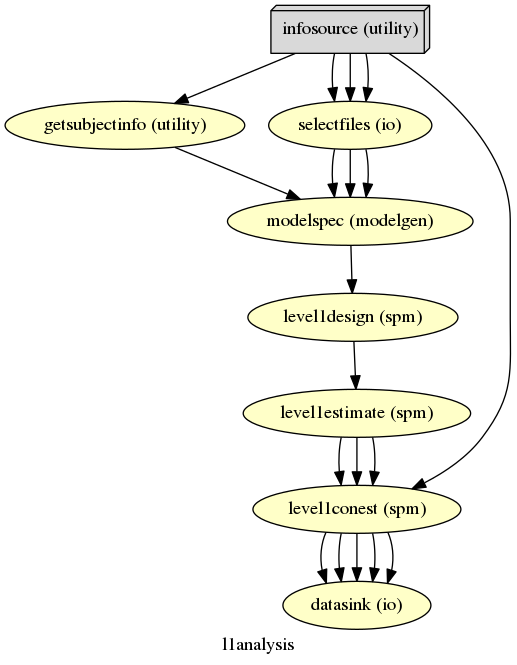

In [32]:
# Create 1st-level analysis output graph# Creat 
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))

In [33]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 10})

181011-11:23:19,759 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
181011-11:23:19,820 nipype.workflow INFO:
	 Running in parallel.
181011-11:23:19,824 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 8 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 10/10.
181011-11:23:19,959 nipype.workflow INFO:
	 [Job 1] Cached (l1analysis.getsubjectinfo).
181011-11:23:19,961 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2797_task_name_tom/selectfiles".181011-11:23:19,968 nipype.workflow INFO:
	 [Job 8] Cached (l1analysis.getsubjectinfo).

181011-11:23:19,973 nipype.workflow INFO:
	 [Job 15] Cached (l1analysis.getsubjectinfo).
181011-11:23:19,974 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")181011-11:23:19,972 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/data/w

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2797_task_name_tom/modelspec/art.asub-2797_task-tom_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181011-11:23:22,18 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181011-11:23:22,46 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181011-11:23:23,828 nipype.workflow INFO:
	 [Job 9] Completed (l1analysis.modelspec).
181011-11:23:23,831 nipype.workflow INFO:
	 [Job 16] Completed (l1analysis.modelspec).
181011-11:23:23,835 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 10/10.
181011-11:23:23,916 nipype.workflow INFO:
	 [Job 3] Cached (l1analysis.level1design).
181011-11:23:23,948 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2797_task_name_tom/level1design".
181011-11:23:23,984 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2958_task_name_tom/level1design".
181011-11:23:23,990 nipype.workflow I